In [ ]:
!conda upgrade scikit-learn -y

In [34]:
from azureml import services
from azureml import Workspace
from azure.servicebus import ServiceBusService

import warnings; warnings.filterwarnings('ignore')

import datetime
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
#from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import requests
import urllib2
import json


from pylab import rcParams
rcParams['figure.figsize'] = 14, 3
%matplotlib inline
pd.options.display.max_colwidth = 500

In [4]:
ws = Workspace()

## Keys and Constants


In [5]:

Anomaly_Detection_KEY = 'put key here'

# Pull in and Pre-Process Data

**Import data**

In [6]:
vel_raw = ws.datasets['vel_raw'].to_dataframe().set_index('time').value
vel_edited = ws.datasets['vel_curated'].to_dataframe().set_index('time').value

df = pd.concat({'velocity': vel_raw, 'velocity_edited': vel_edited}, axis=1, join='inner')
df = df.reset_index()
df['time'] =  pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M')
df = df.set_index('time')

In [8]:
df

,velocity,velocity_edited
time,,
2013-04-01 11:00:00,1.058,1.058
2013-04-01 11:05:00,1.065,1.065
2013-04-01 11:10:00,1.058,1.058
2013-04-01 11:15:00,1.162,1.162
2013-04-01 11:20:00,1.119,1.119
2013-04-01 11:25:00,1.135,1.135
2013-04-01 11:30:00,1.110,1.110
2013-04-01 11:35:00,1.055,1.055
2013-04-01 11:40:00,0.987,0.987


**Generate Velocity N window size of 4**

In [9]:
#create level channels
for i in range(1, 5):
    df['velocity_{}'.format(i)] = df.velocity.shift(i)
df = df.dropna()  

In [13]:
df.head(4)

,velocity,velocity_edited,velocity_1,velocity_2,velocity_3,velocity_4
time,,,,,,
2013-04-01 11:20:00,1.119,1.119,1.162,1.058,1.065,1.058
2013-04-01 11:25:00,1.135,1.135,1.119,1.162,1.058,1.065
2013-04-01 11:30:00,1.110,1.110,1.135,1.119,1.162,1.058
2013-04-01 11:35:00,1.055,1.055,1.110,1.135,1.119,1.162


**Tag Anomolies**

In [10]:
df['diff'] = np.abs(df.velocity - df.velocity_edited)
df['anomaly'] = df['diff'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
df.head(4)

,velocity,velocity_edited,velocity_1,velocity_2,velocity_3,velocity_4,diff,anomaly
time,,,,,,,,
2013-04-01 11:20:00,1.119,1.119,1.162,1.058,1.065,1.058,0.0,0
2013-04-01 11:25:00,1.135,1.135,1.119,1.162,1.058,1.065,0.0,0
2013-04-01 11:30:00,1.110,1.110,1.135,1.119,1.162,1.058,0.0,0
2013-04-01 11:35:00,1.055,1.055,1.110,1.135,1.119,1.162,0.0,0


In [14]:
df[df['anomaly']>0].count()

velocity           495
velocity_edited    495
velocity_1         495
velocity_2         495
velocity_3         495
velocity_4         495
diff               495
anomaly            495
dtype: int64

# Visualize Data

**Check Few Points**

In [17]:
df['2013-04-02 02:30:00':'2013-04-02 02:50:00']

,velocity,velocity_edited,velocity_1,velocity_2,velocity_3,velocity_4,diff,anomaly
time,,,,,,,,
2013-04-02 02:30:00,0.345,0.345000,0.641,0.961,0.930,0.968,0.000000,0
2013-04-02 02:35:00,0.328,0.328000,0.345,0.641,0.961,0.930,0.000000,0
2013-04-02 02:40:00,0.000,0.289756,0.328,0.345,0.641,0.961,0.289756,1
2013-04-02 02:45:00,0.266,0.266000,0.000,0.328,0.345,0.641,0.000000,0
2013-04-02 02:50:00,0.974,0.974000,0.266,0.000,0.328,0.345,0.000000,0


**Plot Sample Daily Pattern**

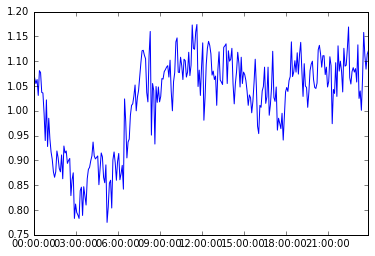

In [15]:
day_df = df['2013-09-03':'2013-09-03']
day_anomalies = day_df[day_df['anomaly']==1]
plt.plot(day_df['velocity'])
plt.scatter(day_anomalies.index, day_anomalies.velocity, color='r')

**Plot Sample Daily Pattern With Anomalies**

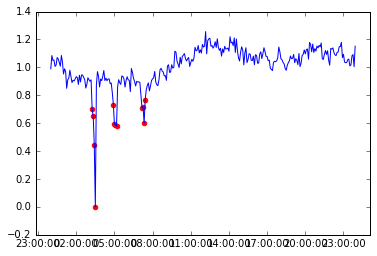

In [19]:
day_df = df['2013-09-02':'2013-09-02']
day_anomalies = day_df[day_df['anomaly']==1]
plt.plot(day_df['velocity'])
plt.scatter(day_anomalies.index, day_anomalies.velocity, color='r')

# Compare Anomaly Detection and Outlier Detection Models

**Define Metrics**

In [16]:
def print_report(expected, predicted):
    target_names = ['Anomalies', 'Regular velocity']
    print("Confusion Matrix")
    print(confusion_matrix(expected, predicted)) 
    print(classification_report(expected, predicted, target_names = target_names))

# Todo Update to reflect the new api
**Model #1 : Outlier Detection** 

- Send the raw data to the [Anomaly Detection API](https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-apps-anomaly-detection-api) to tag outliers
- Score outlier model using [Anomaly Detection API](https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-apps-anomaly-detection-api) results against the 'manually tagged anomalies' 

In [17]:
#Format data for processing 
velDf = vel_raw.to_frame().reset_index()
velDf.value = velDf.value
values = [[parser.parse(t).strftime('%m/%d/%Y %H:%M:%S'),d] for t,d in velDf.values.tolist()]

In [18]:
values

[['04/01/2013 11:00:00', 1.058],
 ['04/01/2013 11:05:00', 1.065],
 ['04/01/2013 11:10:00', 1.058],
 ['04/01/2013 11:15:00', 1.162],
 ['04/01/2013 11:20:00', 1.119],
 ['04/01/2013 11:25:00', 1.135],
 ['04/01/2013 11:30:00', 1.11],
 ['04/01/2013 11:35:00', 1.055],
 ['04/01/2013 11:40:00', 0.987],
 ['04/01/2013 11:45:00', 1.048],
 ['04/01/2013 11:50:00', 0.9840000000000001],
 ['04/01/2013 11:55:00', 1.088],
 ['04/01/2013 12:00:00', 1.0070000000000001],
 ['04/01/2013 12:05:00', 1.058],
 ['04/01/2013 12:10:00', 1.137],
 ['04/01/2013 12:15:00', 1.1520000000000001],
 ['04/01/2013 12:20:00', 1.119],
 ['04/01/2013 12:25:00', 1.062],
 ['04/01/2013 12:30:00', 1.016],
 ['04/01/2013 12:35:00', 0.978],
 ['04/01/2013 12:40:00', 1.077],
 ['04/01/2013 12:45:00', 1.034],
 ['04/01/2013 12:50:00', 1.074],
 ['04/01/2013 12:55:00', 1.068],
 ['04/01/2013 13:00:00', 0.995],
 ['04/01/2013 13:05:00', 1.011],
 ['04/01/2013 13:10:00', 1.014],
 ['04/01/2013 13:15:00', 1.057],
 ['04/01/2013 13:20:00', 1.018],
 ['04

In [22]:
def detectAnomalies(values):
    data = {
            "Inputs": {
                "input1": {
                    "ColumnNames": ["Time", "Data"],
                    "Values": values
                },
            },
            "GlobalParameters": {
                "tspikedetector.sensitivity": "3",
                "zspikedetector.sensitivity": "3",
                "bileveldetector.sensitivity": "3.25",
                "detectors.spikesdips": "Both"
            }

        }

    body = str.encode(json.dumps(data))

    url = 'https://europewest.services.azureml.net/subscriptions/13bbfab4b75b461c98963a55594775f2/services/eb7b355fe6534415ac983c6170756c3c/execute?api-version=2.0&details=true'
    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ Anomaly_Detection_KEY)}

    req = urllib2.Request(url, body, headers)

    try:
        response = urllib2.urlopen(req)

        result = response.read()
        return result
    except urllib2.HTTPError, error:
        print("The request failed with status code: " + str(error.code))

        # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
        print(error.info())
        print(json.loads(error.read())) 

In [20]:
raw_outliers = json.loads(detectAnomalies(values))['Results']['output1']['value']
outliers = pd.DataFrame(raw_outliers['Values'], columns=raw_outliers['ColumnNames'])

In [21]:
outliers['detected_outliers'] = pd.to_numeric(outliers['rpscore']).apply(lambda x: 1 if x > 0 else 0)
print_report(df['anomaly'], outliers[4:]['detected_outliers'])

Confusion Matrix
[[51007  1758]
 [  389   106]]
                  precision    recall  f1-score   support

       Anomalies       0.99      0.97      0.98     52765
Regular velocity       0.06      0.21      0.09       495

     avg / total       0.98      0.96      0.97     53260



**Model #2: Binary Classifier**

- Create a historical window of the previous four velocity channel readings values at each time.  
- Create a train and test set from a random split on the historical windows
- Train a random forest classifier on the train data
- Benchmark the random forest on the test data   

In [23]:
#Define test and training set
columns = ['velocity', 'velocity_1','velocity_2','velocity_3','velocity_4']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df[columns], df.anomaly, test_size=0.3)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
xs = clf.predict(X_test)
print_report(y_test, xs)

Confusion Matrix
[[15839     3]
 [   40    96]]
                  precision    recall  f1-score   support

       Anomalies       1.00      1.00      1.00     15842
Regular velocity       0.97      0.71      0.82       136

     avg / total       1.00      1.00      1.00     15978



**Model #3: Hybrid Classifier**

- Create a historical window of the previous four velocity channel readings values at each time using only the values marked as outliers.  
- Create a train and test set from a random split on the historical windows.
- Train a random forest classifier on the train data.
- Benchmark the random forest on the test data.
- Benchmark the random forest on the entire velocity time series excluding the training set.

In [24]:
detected_outliers = pd.DataFrame({'time':outliers[4:]['Time'],'detected_outliers':outliers[4:]['detected_outliers']})
detected_outliers = detected_outliers[detected_outliers['detected_outliers'] == 1]
detected_outliers['time'] = pd.to_datetime(detected_outliers['time'])
df_outliers = df.loc[detected_outliers['time']]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(df_outliers[columns], df_outliers.anomaly, test_size=0.3)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
xs = clf.predict(X_test)
print_report(y_test, xs)

Confusion Matrix
[[529   4]
 [  7  20]]
                  precision    recall  f1-score   support

       Anomalies       0.99      0.99      0.99       533
Regular velocity       0.83      0.74      0.78        27

     avg / total       0.98      0.98      0.98       560



In [25]:
unseenValues = pd.DataFrame({'time':outliers[4:]['Time'],'detected_outliers':outliers[4:]['detected_outliers']})
unseenValues = unseenValues[unseenValues['detected_outliers'] == 0]
unseenValues['time'] = pd.to_datetime(unseenValues['time'])
unseenValues = df.loc[unseenValues['time']]

oseries = clf.predict(unseenValues[columns])
print_report(unseenValues.anomaly, oseries)

Confusion Matrix
[[50961    46]
 [  106   283]]
                  precision    recall  f1-score   support

       Anomalies       1.00      1.00      1.00     51007
Regular velocity       0.86      0.73      0.79       389

     avg / total       1.00      1.00      1.00     51396



The binary classification model was able to greatly help differentiate between the outliers, anomolies and regular values. While in this data set the anomolies are lineraly seperable in others this technique could be used to yield more accurate results across the 475 sensor errors in the dataset.

## Results

Though the anomoly detection API helped differentiate outliers for anomoly classification, in Carl Data's dataset the difference between anomalies and regular flow was linearly differentiable enough that a random forrest binary classifier was able to provide just as good results as the anomoly detection API without the overhead. 


# Put Model Into Production

In [26]:
@services.publish(ws)
@services.types(curVel = float ,vel1 = float, vel2 = float,vel3 = float, vel4 = float)
@services.returns(int)
def detectAnomaly(curVel,vel1,vel2,vel3,vel4):
    result = clf.predict([curVel,vel1,vel2,vel3,vel4])
    return result[0]

# show information about the web service
serviceInfo = {
                'service_url' : detectAnomaly.service.url,
                'api_key' : detectAnomaly.service.api_key,
                'help_url' : detectAnomaly.service.help_url,
                'service_id' : detectAnomaly.service.service_id,
              }
serviceInfo


{'api_key': u'',
 'help_url': u'https://studio.azureml.net/apihelp/workspaces/08ea9abd7aa547d288334a51b4782062/webservices/a6848a36428748fba994e79b0b9180f5/endpoints/6d49e875a3854670b4bed130f9c20650/score',
 'service_id': 'a6848a36428748fba994e79b0b9180f5',
 'service_url': u'https://ussouthcentral.services.azureml.net/workspaces/08ea9abd7aa547d288334a51b4782062/services/6d49e875a3854670b4bed130f9c20650/execute?api-version=2.0'}

**Test with anomaly**

In [27]:
print(detectAnomaly(0, 0, 0, 0, 10))


1


**Test with normal flow**

In [28]:
print(detectAnomaly(1.119, 1.162, 1.058, 1.065, 1.058))

0


# Create Event Hub For Visualization

**Create an [Eventhub namespace](https://docs.microsoft.com/en-us/azure/event-hubs/event-hubs-resource-manager-namespace-event-hub) from the azure portal and fill in the following**

In [29]:
servns = 'pyconil2017sb'
key_name = 'createandsend'  # SharedAccessKeyName from Azure portal
key_value = '0fvHx77YIng4rn/SsxROp+1kFTd5GJ76WDzo5K5e8ps='  # SharedAccessKey from Azure portal

**Init Service Bus Service**

In [30]:
sbs = ServiceBusService(service_namespace=servns,
                        shared_access_key_name=key_name,
                        shared_access_key_value=key_value) # Create a ServiceBus Service Object


** Create Visualization Event Hub **

In [31]:
anomaly_visulization = sbs.create_event_hub('anomaly_visulization') # Create a Event Hub for the ServiceBus. If it exists then return true, else return false
print(anomaly_visulization)

True


In [32]:
def sendToEventHub(time, curVel, anomoaly):
    event_data = json.dumps({ 'time': time,
                              'curVel': curVel,
                              'anomaly': anomoaly
                             })
    sbs.send_event('anomaly_visulization', event_data)

**Link Visualization Eventhub to [Stream Analytics and PowerBI Embedded](https://docs.microsoft.com/en-us/azure/stream-analytics/stream-analytics-power-bi-dashboard)**

# Simulate a flow sensor and feed the data to our system

In [33]:
for index, row in df['2013-09-02':'2013-09-02'].iterrows():
    anomaly = bool(detectAnomaly(row['velocity'], row['velocity_1'], row['velocity_2'], row['velocity_3'], row['velocity_4']))
    time = (index.strftime("%Y-%m-%d %H:%M:%S"))
    sendToEventHub(time,row['velocity'],anomaly)